In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools



## Toy Model 1
The simulation predicts a summary statistic $f$, 
$$f(x_1) = x_1 + (\text{noise term}).$$
We describe the noise term as draws from a Gaussian with mean $0$ with standard deviation 1.

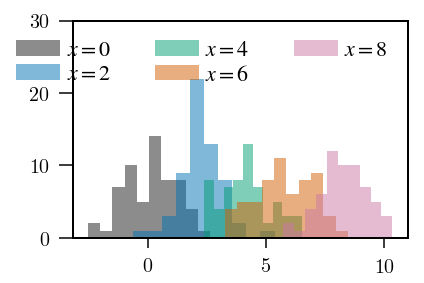

In [2]:
N = 60

def f( x1 ):
    mu, sigma = 0, 1 # mean and standard deviation
    return x1 + np.random.normal(mu, sigma)


params = [0,2,4,6,8]
sample_list = [[f(x) for i in range(N)] for x in params]

for s,p in zip(sample_list, params):
    plt.hist( s, label='$x=' + str(p) + r'$', alpha=0.5 )
plt.ylim(0,30)
plt.legend(ncol=3);

In [3]:
mean_stack = [np.mean(s_i) for s_i in sample_list]
cov = np.cov(sample_list[0])

In [4]:
from scipy.interpolate import Rbf
rbfi = Rbf(params, mean_stack)  # radial basis function interpolator instance

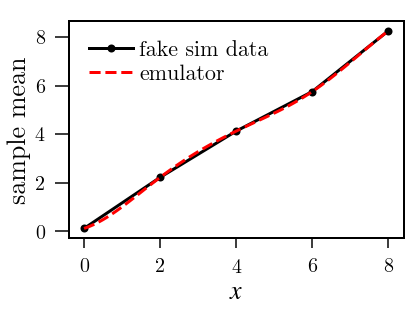

In [5]:
plt.plot( params, mean_stack, 'k-o', markersize=5, label='fake sim data' )

grid = np.linspace(0,8,100)
plt.plot( grid, rbfi(grid), 'r--', label='emulator')
plt.xlabel( '$x$' )
plt.ylabel( 'sample mean' )
plt.legend()

Now we compute the likelihood, which we write as proportional the exponential of $(\mu - x) C^{-1} (\mu-x)$. I choose a fiducial value with $ x= 4$, in which case the posterior should match the true distribution, a Gaussian centered at the fiducial with standard deviation 1.

In [6]:
data = 4.
grid = np.linspace( 0, 8, 100 )

P_list = np.exp( -0.5 * np.array([(data - rbfi(x)) * 1./cov * (data-rbfi(x)) for x in grid]) )

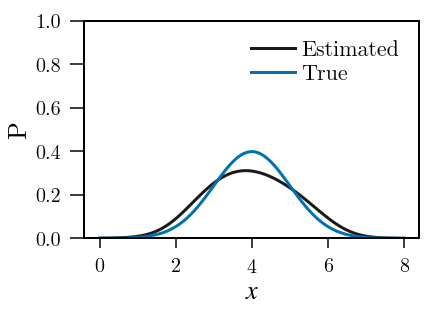

In [7]:
plt.plot( grid, P_list / np.trapz(y=P_list,x=grid), label='Estimated' )
plt.plot( grid, np.exp( -(grid-data)**2 / 2 ) / (np.sqrt(2 * np.pi)),
         label='True' )
plt.ylabel('P')
plt.xlabel(r'$x$')
plt.ylim(0,1)
plt.legend()

# Testing Sub-Emulators

In this case, I compute the likelihood by summing the results from pairs of sub-emulators. I use three sub-emulators, and use the three distinct pairs.

In [8]:
# construct three emulators, 0-20, 20-40, and 40-60

emulator_list = []
cov = np.cov(sample_list[0])
for i in range(3):
    mean_stack = [np.mean(s_i[i*20:i*20+20]) for s_i in sample_list]
    rbfi = Rbf(params, mean_stack)  # radial basis function interpolator instance
    emulator_list.append(rbfi)

In [9]:
def get_combine_P( input_par ):
    chi_sum = 0.0
    data = 4.0
    count = 0
    for ema, emb in itertools.combinations( emulator_list, r=2):
        chi_sum += -0.5 * (data - ema(input_par)) * 1./cov * (data-emb(input_par)) 
        count += 1
    return np.exp(chi_sum/count)

In [10]:
P_list = [get_combine_P(x) for x in grid]

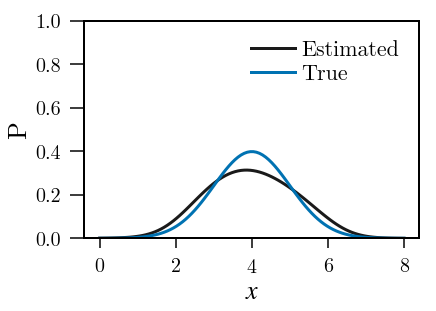

In [11]:
plt.plot( grid, P_list / np.trapz(y=P_list,x=grid), label='Estimated' )
plt.plot( grid, np.exp( -(grid-data)**2 / 2 ) / (np.sqrt(2 * np.pi)), label='True' )
plt.ylabel('P')
plt.xlabel(r'$x$')
plt.ylim(0,1)
plt.legend()

looks about the same